In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = None

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `local` if `census_uri` is a local path
# - current region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
census_loc = None

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024
n_vars = 20_000
soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
census_uri = ""


In [4]:
var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    experiment = Experiment.open(experiment_uri)
    obs_query = None
else:
    if not census_uri:
        census_uri = None
    
    if census_loc is None:
        if census_uri and census_uri.startswith('/'):
            census_loc = 'local'
        else:
            census_loc = get_region()
    
    err(f"Loading census ({census_loc})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_datasets(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)
experiment

Loading census (us-east-1)


138 datasets: ['8e10f1c4-8e98-41e5-b65f-8cd89a887122', 'b165f033-9dec-468a-9248-802fc6902a74', 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded', 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd', 'fbf173f9-f809-4d84-9b65-ae205d35b523', 'fa554686-fc07-44dd-b2de-b726d82d26ec', 'f9034091-2e8f-4ac6-9874-e7b7eb566824', 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d', 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67', 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']


<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [5]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 4.37 ms, sys: 192 µs, total: 4.56 ms
Wall time: 5.85 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7fcdc01310d0>)

In [6]:
%%time
exp.datapipe.shape[0]

CPU times: user 9.29 s, sys: 2.64 s, total: 11.9 s
Wall time: 9.9 s


133790

## Run benchmark

In [7]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(exp, batch_size=batch_size, gc_freq=gc_freq, exclude_first_batch=exclude_first_batch)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

  0%|                                                                                              | 0/130 [00:00<?, ?it/s]

  1%|▋                                                                                     | 1/130 [00:00<00:16,  7.84it/s]

  2%|█▎                                                                                    | 2/130 [00:01<02:18,  1.08s/it]

  2%|█▉                                                                                    | 3/130 [00:02<01:22,  1.54it/s]

  3%|██▋                                                                                   | 4/130 [00:02<00:55,  2.25it/s]

  4%|███▎                                                                                  | 5/130 [00:02<00:41,  3.02it/s]

  5%|███▉                                                                                  | 6/130 [00:02<00:32,  3.81it/s]

  5%|████▋                                                                                 | 7/130 [00:02<00:26,  4.56it/s]

  6%|█████▎                                                                                | 8/130 [00:02<00:24,  4.89it/s]

  7%|█████▉                                                                                | 9/130 [00:14<07:24,  3.68s/it]

  8%|██████▌                                                                              | 10/130 [00:14<05:09,  2.58s/it]

  8%|███████▏                                                                             | 11/130 [00:15<04:40,  2.36s/it]

  9%|███████▊                                                                             | 12/130 [00:16<03:17,  1.68s/it]

 10%|████████▌                                                                            | 13/130 [00:16<02:20,  1.20s/it]

 11%|█████████▏                                                                           | 14/130 [00:16<01:40,  1.15it/s]

 12%|█████████▊                                                                           | 15/130 [00:16<01:13,  1.56it/s]

 12%|██████████▍                                                                          | 16/130 [00:16<00:54,  2.09it/s]

 13%|███████████                                                                          | 17/130 [00:16<00:41,  2.72it/s]

 14%|███████████▊                                                                         | 18/130 [00:23<04:26,  2.38s/it]

 15%|████████████▍                                                                        | 19/130 [00:23<03:08,  1.69s/it]

 15%|█████████████                                                                        | 20/130 [00:25<03:03,  1.67s/it]

 16%|█████████████▋                                                                       | 21/130 [00:25<02:11,  1.20s/it]

 18%|███████████████                                                                      | 23/130 [00:25<01:14,  1.45it/s]

 19%|████████████████▎                                                                    | 25/130 [00:25<00:47,  2.19it/s]

 21%|█████████████████▋                                                                   | 27/130 [00:34<03:16,  1.90s/it]

 22%|██████████████████▎                                                                  | 28/130 [00:34<02:36,  1.54s/it]

 22%|██████████████████▉                                                                  | 29/130 [00:35<02:03,  1.22s/it]

 23%|███████████████████▌                                                                 | 30/130 [00:37<02:22,  1.42s/it]

 24%|████████████████████▎                                                                | 31/130 [00:37<01:47,  1.09s/it]

 25%|████████████████████▉                                                                | 32/130 [00:37<01:21,  1.20it/s]

 25%|█████████████████████▌                                                               | 33/130 [00:37<01:01,  1.57it/s]

 26%|██████████████████████▏                                                              | 34/130 [00:37<00:47,  2.03it/s]

 27%|██████████████████████▉                                                              | 35/130 [00:37<00:37,  2.57it/s]

 28%|███████████████████████▌                                                             | 36/130 [00:37<00:29,  3.19it/s]

 28%|████████████████████████▏                                                            | 37/130 [00:51<06:38,  4.28s/it]

 29%|████████████████████████▊                                                            | 38/130 [00:51<04:40,  3.05s/it]

 30%|█████████████████████████▌                                                           | 39/130 [00:53<04:01,  2.66s/it]

 31%|██████████████████████████▏                                                          | 40/130 [00:53<02:51,  1.90s/it]

 32%|██████████████████████████▊                                                          | 41/130 [00:53<02:01,  1.37s/it]

 32%|███████████████████████████▍                                                         | 42/130 [00:53<01:27,  1.01it/s]

 33%|████████████████████████████                                                         | 43/130 [00:54<01:03,  1.37it/s]

 34%|████████████████████████████▊                                                        | 44/130 [00:54<00:46,  1.84it/s]

 35%|█████████████████████████████▍                                                       | 45/130 [00:54<00:35,  2.42it/s]

 35%|██████████████████████████████                                                       | 46/130 [01:02<03:42,  2.64s/it]

 36%|██████████████████████████████▋                                                      | 47/130 [01:02<02:36,  1.89s/it]

 37%|███████████████████████████████▍                                                     | 48/130 [01:02<01:51,  1.35s/it]

 38%|████████████████████████████████                                                     | 49/130 [01:04<01:59,  1.48s/it]

 38%|████████████████████████████████▋                                                    | 50/130 [01:04<01:25,  1.06s/it]

 39%|█████████████████████████████████▎                                                   | 51/130 [01:04<01:01,  1.29it/s]

 40%|██████████████████████████████████                                                   | 52/130 [01:04<00:44,  1.74it/s]

 41%|██████████████████████████████████▋                                                  | 53/130 [01:04<00:33,  2.30it/s]

 42%|███████████████████████████████████▎                                                 | 54/130 [01:04<00:25,  2.98it/s]

 42%|███████████████████████████████████▉                                                 | 55/130 [01:12<03:18,  2.64s/it]

 43%|████████████████████████████████████▌                                                | 56/130 [01:12<02:19,  1.89s/it]

 44%|█████████████████████████████████████▎                                               | 57/130 [01:14<02:11,  1.80s/it]

 45%|█████████████████████████████████████▉                                               | 58/130 [01:14<01:33,  1.29s/it]

 45%|██████████████████████████████████████▌                                              | 59/130 [01:14<01:06,  1.07it/s]

 46%|███████████████████████████████████████▏                                             | 60/130 [01:14<00:48,  1.45it/s]

 47%|███████████████████████████████████████▉                                             | 61/130 [01:14<00:35,  1.94it/s]

 48%|████████████████████████████████████████▌                                            | 62/130 [01:14<00:26,  2.55it/s]

 48%|█████████████████████████████████████████▏                                           | 63/130 [01:15<00:20,  3.25it/s]

 49%|█████████████████████████████████████████▊                                           | 64/130 [01:15<00:17,  3.84it/s]

 50%|██████████████████████████████████████████▌                                          | 65/130 [01:23<02:50,  2.63s/it]

 52%|███████████████████████████████████████████▊                                         | 67/130 [01:23<01:32,  1.46s/it]

 53%|█████████████████████████████████████████████                                        | 69/130 [01:23<00:56,  1.09it/s]

 54%|█████████████████████████████████████████████▊                                       | 70/130 [01:23<00:44,  1.34it/s]

 55%|██████████████████████████████████████████████▍                                      | 71/130 [01:28<01:35,  1.62s/it]

 55%|███████████████████████████████████████████████                                      | 72/130 [01:28<01:11,  1.23s/it]

 56%|███████████████████████████████████████████████▋                                     | 73/130 [01:28<00:53,  1.07it/s]

 57%|████████████████████████████████████████████████▍                                    | 74/130 [01:38<03:09,  3.38s/it]

 58%|█████████████████████████████████████████████████                                    | 75/130 [01:38<02:15,  2.46s/it]

 58%|█████████████████████████████████████████████████▋                                   | 76/130 [01:40<02:01,  2.25s/it]

 59%|██████████████████████████████████████████████████▎                                  | 77/130 [01:40<01:26,  1.64s/it]

 60%|███████████████████████████████████████████████████                                  | 78/130 [01:40<01:02,  1.19s/it]

 61%|███████████████████████████████████████████████████▋                                 | 79/130 [01:40<00:44,  1.14it/s]

 62%|████████████████████████████████████████████████████▎                                | 80/130 [01:40<00:32,  1.52it/s]

 62%|████████████████████████████████████████████████████▉                                | 81/130 [01:40<00:24,  1.99it/s]

 63%|█████████████████████████████████████████████████████▌                               | 82/130 [01:40<00:19,  2.51it/s]

 64%|██████████████████████████████████████████████████████▎                              | 83/130 [01:48<02:04,  2.65s/it]

 65%|██████████████████████████████████████████████████████▉                              | 84/130 [01:48<01:27,  1.89s/it]

 65%|███████████████████████████████████████████████████████▌                             | 85/130 [01:50<01:23,  1.85s/it]

 66%|████████████████████████████████████████████████████████▏                            | 86/130 [01:50<00:58,  1.33s/it]

 67%|████████████████████████████████████████████████████████▉                            | 87/130 [01:50<00:41,  1.03it/s]

 68%|█████████████████████████████████████████████████████████▌                           | 88/130 [01:51<00:29,  1.41it/s]

 68%|██████████████████████████████████████████████████████████▏                          | 89/130 [01:51<00:21,  1.89it/s]

 69%|██████████████████████████████████████████████████████████▊                          | 90/130 [01:51<00:16,  2.49it/s]

 70%|███████████████████████████████████████████████████████████▍                         | 91/130 [01:51<00:12,  3.18it/s]

 71%|████████████████████████████████████████████████████████████▏                        | 92/130 [01:51<00:09,  3.82it/s]

 72%|████████████████████████████████████████████████████████████▊                        | 93/130 [02:00<01:43,  2.81s/it]

 72%|█████████████████████████████████████████████████████████████▍                       | 94/130 [02:00<01:12,  2.01s/it]

 73%|██████████████████████████████████████████████████████████████                       | 95/130 [02:02<01:05,  1.88s/it]

 74%|██████████████████████████████████████████████████████████████▊                      | 96/130 [02:02<00:46,  1.36s/it]

 75%|███████████████████████████████████████████████████████████████▍                     | 97/130 [02:02<00:32,  1.01it/s]

 75%|████████████████████████████████████████████████████████████████                     | 98/130 [02:02<00:23,  1.37it/s]

 76%|████████████████████████████████████████████████████████████████▋                    | 99/130 [02:02<00:17,  1.81it/s]

 77%|████████████████████████████████████████████████████████████████▌                   | 100/130 [02:02<00:12,  2.35it/s]

 78%|█████████████████████████████████████████████████████████████████▎                  | 101/130 [02:02<00:10,  2.83it/s]

 78%|█████████████████████████████████████████████████████████████████▉                  | 102/130 [02:10<01:08,  2.44s/it]

 79%|██████████████████████████████████████████████████████████████████▌                 | 103/130 [02:10<00:46,  1.74s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 104/130 [02:10<00:32,  1.25s/it]

 81%|███████████████████████████████████████████████████████████████████▊                | 105/130 [02:12<00:35,  1.41s/it]

 82%|█████████████████████████████████████████████████████████████████████▏              | 107/130 [02:12<00:18,  1.24it/s]

 83%|█████████████████████████████████████████████████████████████████████▊              | 108/130 [02:12<00:13,  1.59it/s]

 84%|██████████████████████████████████████████████████████████████████████▍             | 109/130 [02:12<00:10,  2.03it/s]

 85%|███████████████████████████████████████████████████████████████████████             | 110/130 [02:12<00:07,  2.59it/s]

 85%|███████████████████████████████████████████████████████████████████████▋            | 111/130 [02:19<00:41,  2.19s/it]

 87%|█████████████████████████████████████████████████████████████████████████           | 113/130 [02:19<00:21,  1.26s/it]

 88%|█████████████████████████████████████████████████████████████████████████▋          | 114/130 [02:21<00:21,  1.35s/it]

 89%|██████████████████████████████████████████████████████████████████████████▉         | 116/130 [02:21<00:11,  1.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 117/130 [02:21<00:08,  1.48it/s]

 92%|████████████████████████████████████████████████████████████████████████████▉       | 119/130 [02:21<00:04,  2.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▌      | 120/130 [02:21<00:03,  2.65it/s]

 93%|██████████████████████████████████████████████████████████████████████████████▏     | 121/130 [02:29<00:19,  2.12s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 122/130 [02:29<00:12,  1.61s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 123/130 [02:29<00:08,  1.22s/it]

 95%|████████████████████████████████████████████████████████████████████████████████    | 124/130 [02:30<00:05,  1.09it/s]

 96%|████████████████████████████████████████████████████████████████████████████████▊   | 125/130 [02:30<00:03,  1.44it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 126/130 [02:30<00:02,  1.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████  | 127/130 [02:30<00:01,  2.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████▋ | 128/130 [02:30<00:00,  3.04it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 129/130 [02:30<00:00,  3.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:31<00:00,  2.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 130/130 [02:31<00:00,  1.16s/it]

time per sample: 1137.39 μs
samples per sec: 879.21 samples/sec
CPU times: user 1min 51s, sys: 51.4 s, total: 2min 43s
Wall time: 2min 51s


In [8]:
tdb.stats

{'open_soma': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 0.078558,
    'Context.StorageManager.sm_load_group_metadata.avg': 0.078558,
    'Context.StorageManager.sm_load_group_from_uri.sum': 0.0948156,
    'Context.StorageManager.sm_load_group_from_uri.avg': 0.0948156,
    'Context.StorageManager.sm_load_group_details.sum': 0.094837,
    'Context.StorageManager.sm_load_group_details.avg': 0.094837,
    'Context.StorageManager.group_open_for_reads.sum': 0.0948399,
    'Context.StorageManager.group_open_for_reads.avg': 0.0948399},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 373,
    'Context.StorageManager.read_group_size': 104,
    'Context.StorageManager.read_array_meta_size': 269,
    'Context.StorageManager.VFS.read_ops_num': 9,
    'Context.StorageManager.VFS.read_byte_num': 504,
    'Context.StorageManager.VFS.ls_num': 3,
    'Context.StorageManager.VFS.is_object_num': 1}}],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_grou

In [9]:
tdbs.stats

{'open_soma': [],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_fragment_metadata.sum': 0.312475,
    'Context.StorageManager.sm_load_fragment_metadata.avg': 0.156238,
    'Context.StorageManager.sm_load_filtered_fragment_uris.sum': 5.3363e-05,
    'Context.StorageManager.sm_load_filtered_fragment_uris.avg': 2.66815e-05,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.sum': 0.411806,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.avg': 0.205903,
    'Context.StorageManager.sm_load_array_schema_from_uri.sum': 0.0982791,
    'Context.StorageManager.sm_load_array_schema_from_uri.avg': 0.0491395,
    'Context.StorageManager.sm_load_array_metadata.sum': 0.0715512,
    'Context.StorageManager.sm_load_array_metadata.avg': 0.0715512,
    'Context.StorageManager.sm_load_all_array_schemas.sum': 0.0983075,
    'Context.StorageManager.sm_load_all_array_schemas.avg': 0.0491538,
    'Context.StorageManager.array_open_read_load_schemas_and_

In [10]:
results_json_path = f'results/{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/us-east-1.json


In [11]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [12]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_5202/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.128929
1,1,1.752463
2,2,0.136541
3,3,0.126779
4,4,0.131371
...,...,...
125,125,0.113266
126,126,0.136624
127,127,0.124696
128,128,0.129637


In [13]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
1,1,1.752463
8,8,11.306602
10,10,1.857610
17,17,7.050571
19,19,1.618716
26,26,8.813518
29,29,2.048048
36,36,13.792218
38,38,1.719484
45,45,7.857027


In [14]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-us-east-1.png


Returning IPython Image


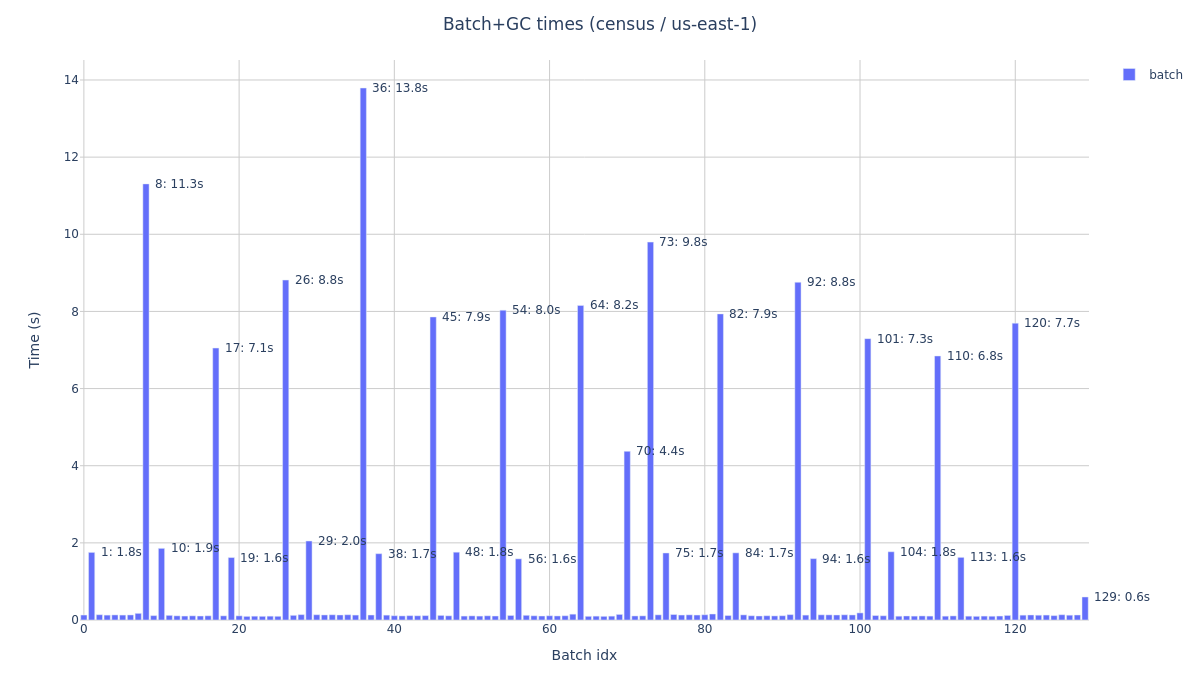

In [15]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)